In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
from NERmodel import TokenClassifier
from NER_ground_truth import ner_data
if 'plot' in sys.modules:
    del sys.modules['plot']
import plot
from sklearn.model_selection import train_test_split
import numpy as np

Create a number for each label in the dataset. This approach is not extensible: if the manufacturer is not present in the training data, the model won't be able to predict it.

In [7]:
labels_str = [
    "None",
    "Pieces",
    "Manufacturer",
    "SubType",
    "HxType",
    "kW",
    "Year"
]

# NER token classifier l1

In [3]:
ner_gt = ner_data('../data/data_district_heating.xlsx')
ner_gt.head()

100%|██████████| 2272/2272 [02:01<00:00, 18.76it/s]


,text,words,tokens,labels
0,Fjernvarme med isoleret veksler (indirekte anl...,"[fjernvarme, med, isoleret, veksler, (, indire...","[[tensor(1.0188), tensor(1.2181), tensor(0.024...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."
1,Eksisterende fjernvarme,"[eksisterende, fjernvarme]","[[tensor(1.0928), tensor(0.8145), tensor(0.337...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."
2,Fjernvarme med uisoleret veksler (indirekte an...,"[fjernvarme, med, uisoleret, veksler, (, indir...","[[tensor(1.0735), tensor(1.2092), tensor(0.108...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."
3,Fjernvarme med isoleret veksler (indirekte anl...,"[fjernvarme, med, isoleret, veksler, (, indire...","[[tensor(0.8679), tensor(1.1397), tensor(-0.12...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."
4,Fjernvarme med isoleret veksler (indirekte anl...,"[fjernvarme, med, isoleret, veksler, (, indire...","[[tensor(1.0224), tensor(1.1423), tensor(0.114...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...."


In [4]:
model = TokenClassifier()
X_train, X_test, y_train, y_test, words_train, words_test = train_test_split(ner_gt['tokens'].values, ner_gt['labels'].values, ner_gt['words'].values, test_size=.2, random_state=42)

In [5]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

Starting training with batch size 16


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9875912880501518

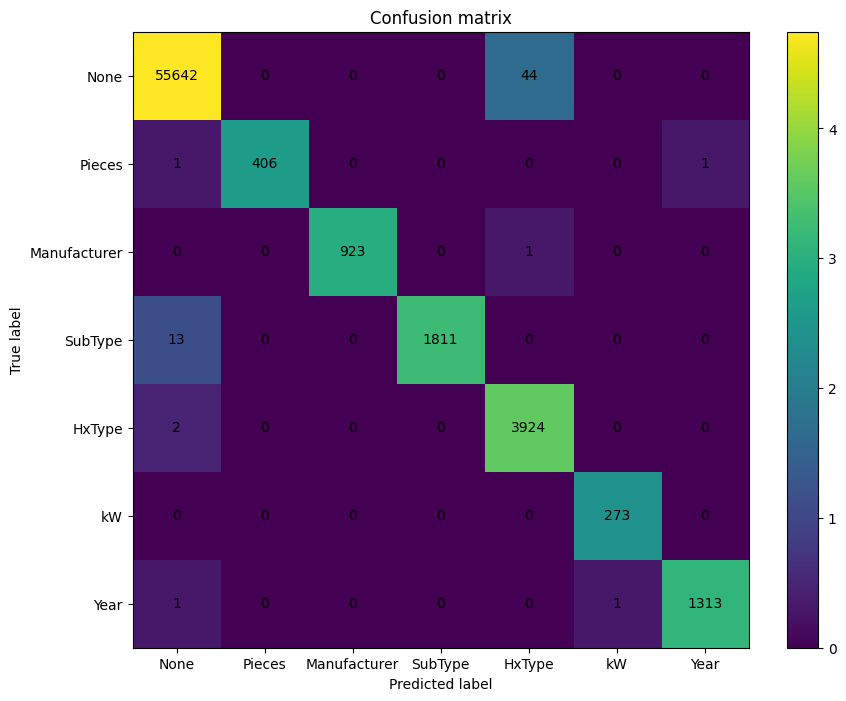

In [25]:
pred = model.predict(X_train)
y_train_ref = []
for labels in range(len(y_train)):
    y_train_ref.append(np.argmax(y_train[labels], axis=1))
plot.confusion_matrix(y_train_ref, pred, labels_str, title="Confusion Matrix - Training Set")

In [26]:
def plot_sample(i, pred, target, words):
    masks = []
    for labels in range(len(pred)):
        masks.append(np.where(target[labels] != pred[labels]))
    print(f"Sample {i}:")
    print("Predicted:", pred[i])
    print("Expected:", target[i])
    print("Mismatch indices:", masks[i][0])
    print("Sentence:", " ".join(words[i]))
    for m in masks[i][0]:
        print("Words:", words[i][m])
        print("Predicted label:", pred[i][m])
        print("Expected label:", target[i][m])
    print()

In [27]:
def extract_mistakes(pred, target, words):
    masks = []
    mm_word = []
    mm_pred = []
    mm_target = []
    for labels in range(len(pred)):
        masks.append(np.where(target[labels] != pred[labels]))
    mismatched_samples = [i for i in range(len(masks)) if len(masks[i][0]) > 0]
    for mm in mismatched_samples:
        mm_word.extend([words[mm][m] for m in masks[mm][0]])
        mm_pred.extend([pred[mm][m] for m in masks[mm][0]])
        mm_target.extend([target[mm][m] for m in masks[mm][0]])
    return mismatched_samples, masks, mm_word, mm_pred, mm_target

In [28]:
mm_samples, mm_masks, mm_word, mm_pred, mm_target = extract_mistakes(pred, y_train_ref, words_train)
mm_word_set = set(mm_word)
print(f"Number of mismatched unique words: {len(mm_word_set)}")
counts = {w: mm_word.count(w) for w in mm_word_set}
for k, v in counts.items():
    print(f"{k}: {v}")

Number of mismatched unique words: 9
m: 1
isoleret: 35
4: 1
uisoleret: 9
fjernvarmeveksler: 1
1: 1
varmeveksler: 1
1980: 2
-: 13


In [29]:
masked_labeld = []
for labels in y_train_ref:
    masked = labels != 0
    masked_labeld.append([i for i, masked in enumerate(masked) if masked])

labeled_words = []

for labels in range(len(words_train)):
    words = [word for i, word in enumerate(words_train[labels]) if i in masked_labeld[labels]]
    labeled_words.extend(words)

print(len(labeled_words))
print(len(set(labeled_words)))
counts = {w: labeled_words.count(w) for w in set(labeled_words)}
labeled_words_df = pd.DataFrame(counts.items(), columns=['word', 'count'])
labeled_words_df = labeled_words_df.sort_values(by='count', ascending=False)
labeled_words_df.head(30)

8670
359


,word,count
207,isoleret,2208
211,varmeveksler,1194
128,-,1175
48,1,278
14,1980,184
350,reci,180
93,2,163
108,fjernvarmeveksler,153
95,kw,141
13,uisoleret,119


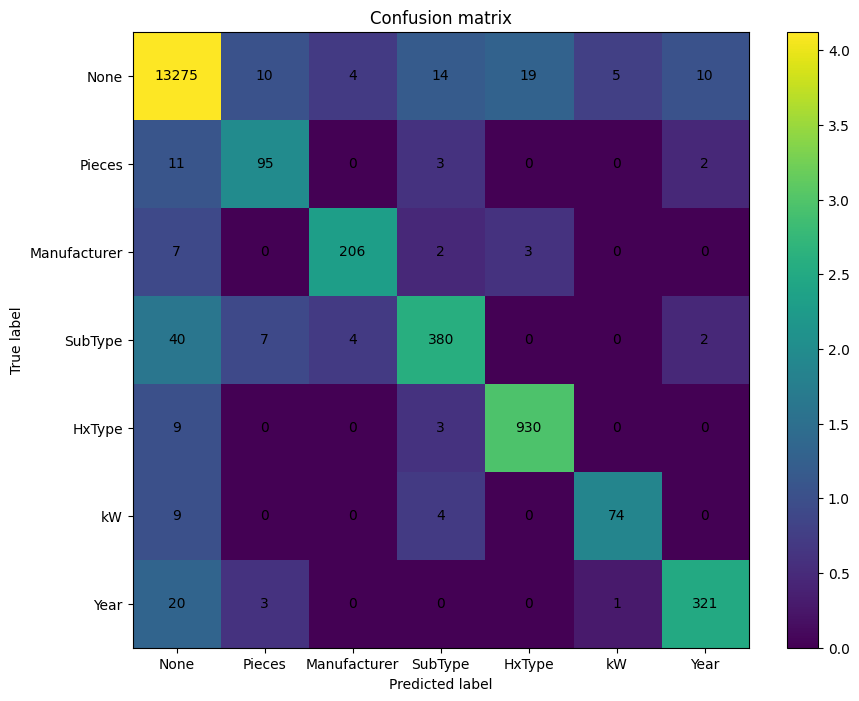

In [30]:
test_pred = model.predict(X_test)
y_test_ref = []
for labels in range(len(y_test)):
    y_test_ref.append(np.argmax(y_test[labels], axis=1))
plot.confusion_matrix(y_test_ref, test_pred, labels_str, title="Confusion Matrix - Test Set")

In [32]:
eval_mm_samples, eval_mm_masks, eval_mm_word, eval_mm_pred, eval_mm_target = extract_mistakes(test_pred, y_test_ref, words_test)
eval_mm_word_set = set(eval_mm_word)
print(f"Number of mismatched unique words: {len(eval_mm_word_set)}")
eval_counts = {w: eval_mm_word.count(w) for w in eval_mm_word_set}
eval_counts_df = pd.DataFrame(eval_counts.items(), columns=['word', 'count'])
eval_counts_df = eval_counts_df.sort_values(by='count', ascending=False)
eval_counts_df.head(30)

Number of mismatched unique words: 70


,word,count
13,-,47
32,2,13
46,1,11
2,isoleret,10
5,4,7
39,kw,6
50,1980,6
59,m,5
54,3,4
41,reci,4
